## Step 1 Install required packages

In [1]:
# !pip install rlschool==0.3.1
# !pip install parl==1.3.1

## Step 2 Import required packages

In [6]:
import os
import numpy as np

import parl
from parl import layers
from paddle import fluid
from parl.utils import logger
from parl.utils import action_mapping # 将神经网络输出映射到对应的 实际动作取值范围 内
from parl.utils import ReplayMemory # 经验回放

from rlschool import make_env  # 使用 RLSchool 创建飞行器环境

## Step 3 Set parameters

In [7]:
######################################################################
######################################################################
#
# 1. 请设定 learning rate，尝试增减查看效果
#
######################################################################
######################################################################
ACTOR_LR = 1e-3   # Actor网络更新的 learning rate
CRITIC_LR = 1e-3   # Critic网络更新的 learning rate

GAMMA = 0.95        # reward 的衰减因子，一般取 0.9 到 0.999 不等
TAU = 0.005         # target_model 跟 model 同步参数 的 软更新参数
MEMORY_SIZE = int(1e6)   # replay memory的大小，越大越占用内存
WARMUP_SIZE = 1e4      # replay_memory 里需要预存一些经验数据，再从里面sample一个batch的经验让agent去learn
REWARD_SCALE = 0.1       # reward 的缩放因子
BATCH_SIZE = 256          # 每次给agent learn的数据数量，从replay memory随机里sample一批数据出来
TRAIN_TOTAL_STEPS = 1e6   # 总训练步数
TEST_EVERY_STEPS = 1e4    # 每个N步评估一下算法效果，每次评估5个episode求平均reward
EXPL_NOISE = 0.1         # 添加噪声系数

## Step 4 Set up Model, Algorithm and Agent

### （1）Model

In [8]:
class ActorModel(parl.Model):
    def __init__(self, act_dim, max_action):
        hid1_size = 300
        hid2_size = 300

        self.fc1 = layers.fc(size=hid1_size, act='tanh')
        self.fc2 = layers.fc(size=hid2_size, act='tanh')
        self.fc3 = layers.fc(size=act_dim, act='tanh')

        self.max_action = max_action
        ######################################################################
        ######################################################################
        #
        # 2. 配置model结构
        #
        ######################################################################
        ######################################################################

    def policy(self, obs):
        ######################################################################
        ######################################################################
        #
        # 3. 组装policy网络
        #
        ######################################################################
        ######################################################################
        hid1 = self.fc1(obs)
        hid2 = self.fc2(hid1)
        means = self.fc3(hid2)
        means = means * self.max_action
        return means

In [9]:
class CriticModel(parl.Model):
    def __init__(self, act_dim):
        ######################################################################
        ######################################################################
        #
        # 4. 配置model结构
        #
        ######################################################################
        ######################################################################
        hid1_size = 300
        hid2_size = 300

        self.fc1 = layers.fc(size=hid1_size, act='tanh')
        self.fc2 = layers.fc(size=hid2_size + act_dim, act='tanh')
        self.fc3 = layers.fc(size=1, act=None)

        self.fc4 = layers.fc(size=hid1_size, act='tanh')
        self.fc5 = layers.fc(size=hid2_size + act_dim, act='tanh')
        self.fc6 = layers.fc(size=1, act=None)
  

    def value(self, obs, act):
        # 输入 state, action, 输出对应的Q(s,a)

        ######################################################################
        ######################################################################
        #
        # 5. 组装Q网络
        #
        ######################################################################
        ######################################################################
        hid1 = self.fc1(obs)
        concat1 = layers.concat([hid1, act], axis=1)
        Q1 = self.fc2(concat1)
        Q1 = self.fc3(Q1)
        Q1 = layers.squeeze(Q1, axes=[1])

        hid2 = self.fc4(obs)
        concat2 = layers.concat([hid2, act], axis=1)
        Q2 = self.fc5(concat2)
        Q2 = self.fc6(Q2)
        Q2 = layers.squeeze(Q2, axes=[1])
        return Q1, Q2

    def Q1(self, obs, act):
        hid1 = self.fc1(obs)
        concat1 = layers.concat([hid1, act], axis=1)
        Q1 = self.fc2(concat1)
        Q1 = self.fc3(Q1)
        Q1 = layers.squeeze(Q1, axes=[1])

        return Q1

In [10]:
class QuadrotorModel(parl.Model):
    def __init__(self, act_dim, max_action):
        self.actor_model = ActorModel(act_dim, max_action)
        self.critic_model = CriticModel(act_dim)

    def policy(self, obs):
        return self.actor_model.policy(obs)

    def value(self, obs, act):
        return self.critic_model.value(obs, act)

    def Q1(self, obs, act):
        return self.critic_model.Q1(obs, act)

    def get_actor_params(self):
        return self.actor_model.parameters()

### （2）Algorithm

In [11]:
from parl.algorithms import TD3

### （3）Agent

In [12]:

class QuadrotorAgent(parl.Agent):
    def __init__(self, algorithm, obs_dim, act_dim):
        assert isinstance(obs_dim, int)
        assert isinstance(act_dim, int)
        self.obs_dim = obs_dim
        self.act_dim = act_dim
        super(QuadrotorAgent, self).__init__(algorithm)

        # Attention: In the beginning, sync target model totally.
        self.alg.sync_target(decay=0)
        self.learn_it = 0
        self.policy_freq = self.alg.policy_freq

    def build_program(self):
        self.pred_program = fluid.Program()
        self.actor_learn_program = fluid.Program()
        self.critic_learn_program = fluid.Program()

        with fluid.program_guard(self.pred_program):
            obs = layers.data(
                name='obs', shape=[self.obs_dim], dtype='float32')
            self.pred_act = self.alg.predict(obs)

        with fluid.program_guard(self.actor_learn_program):
            obs = layers.data(
                name='obs', shape=[self.obs_dim], dtype='float32')
            self.actor_cost = self.alg.actor_learn(obs)

        with fluid.program_guard(self.critic_learn_program):
            obs = layers.data(
                name='obs', shape=[self.obs_dim], dtype='float32')
            act = layers.data(
                name='act', shape=[self.act_dim], dtype='float32')
            reward = layers.data(name='reward', shape=[], dtype='float32')
            next_obs = layers.data(
                name='next_obs', shape=[self.obs_dim], dtype='float32')
            terminal = layers.data(name='terminal', shape=[], dtype='bool')
            self.critic_cost = self.alg.critic_learn(obs, act, reward,
                                                     next_obs, terminal)

    def predict(self, obs):
        obs = np.expand_dims(obs, axis=0)
        act = self.fluid_executor.run(
            self.pred_program, feed={'obs': obs},
            fetch_list=[self.pred_act])[0]
        return act

    def learn(self, obs, act, reward, next_obs, terminal):
        self.learn_it += 1
        feed = {
            'obs': obs,
            'act': act,
            'reward': reward,
            'next_obs': next_obs,
            'terminal': terminal
        }
        critic_cost = self.fluid_executor.run(
            self.critic_learn_program,
            feed=feed,
            fetch_list=[self.critic_cost])[0]

        actor_cost = None
        if self.learn_it % self.policy_freq == 0:
            actor_cost = self.fluid_executor.run(
                self.actor_learn_program,
                feed={'obs': obs},
                fetch_list=[self.actor_cost])[0]
            self.alg.sync_target()
        return actor_cost, critic_cost

    def save(self, save_path, mode, program=None):
        """Save parameters.
        Args:
            save_path(str): where to save the parameters.
            program(fluid.Program): program that describes the neural network structure. If None, will use self.learn_program.
        Raises:
            ValueError: if program is None and self.learn_program does not exist.
        Example:
        .. code-block:: python
            agent = AtariAgent()
            agent.save('./model.ckpt')
        """
        if mode == "train_actor":
            save_program = self.actor_learn_program
        elif mode == "train_critic":
            save_program = self.critic_learn_program
        elif mode == "predict":
            save_program = self.pred_program
        else:
            save_program = self.pred_program
        if program is None:
            program = save_program
        dirname = os.sep.join(save_path.split(os.sep)[:-1])
        filename = save_path.split(os.sep)[-1]
        fluid.io.save_params(
            executor=self.fluid_executor,
            dirname=dirname,
            main_program=program,
            filename=filename)

    def restore(self, save_path, mode, program=None):
        """Restore previously saved parameters.
        This method requires a program that describes the network structure.
        The save_path argument is typically a value previously passed to ``save_params()``.
        Args:
            save_path(str): path where parameters were previously saved.
            program(fluid.Program): program that describes the neural network structure. If None, will use self.learn_program.
        Raises:
            ValueError: if program is None and self.learn_program does not exist.
        Example:
        .. code-block:: python
            agent = AtariAgent()
            agent.save('./model.ckpt')
            agent.restore('./model.ckpt')
        """
        if mode == "train_actor":
            save_program = self.actor_learn_program
        elif mode == "train_critic":
            save_program = self.critic_learn_program
        elif mode == "predict":
            save_program = self.pred_program
        else:
            save_program = self.pred_program 
        if program is None:
            program = save_program
        if type(program) is fluid.compiler.CompiledProgram:
            program = program._init_program
        dirname = os.sep.join(save_path.split(os.sep)[:-1])
        filename = save_path.split(os.sep)[-1]
        fluid.io.load_params(
            executor=self.fluid_executor,
            dirname=dirname,
            main_program=program,
            filename=filename)

## Step 5 Training && Test

In [13]:
def run_episode(env, agent, rpm):
    obs = env.reset()
    total_reward = 0
    steps = 0
    max_action = float(env.action_space.high[0])
    while True:
        steps += 1
        batch_obs = np.expand_dims(obs, axis=0)

        if rpm.size() < WARMUP_SIZE:
            action = env.action_space.sample()
        else:
            action = agent.predict(batch_obs.astype('float32'))
            action = np.squeeze(action)

            # Add exploration noise, and clip to [-max_action, max_action]
            action = np.clip(
                np.random.normal(action, EXPL_NOISE * max_action), -max_action,
                max_action)

        next_obs, reward, done, info = env.step(action)

        rpm.append(obs, action, reward, next_obs, done)

        if rpm.size() > WARMUP_SIZE:
            batch_obs, batch_action, batch_reward, batch_next_obs, batch_terminal = rpm.sample_batch(
                BATCH_SIZE)
            agent.learn(batch_obs, batch_action, batch_reward, batch_next_obs,
                        batch_terminal)

        obs = next_obs
        total_reward += reward

        if done:
            break
    return total_reward, steps


# 评估 agent, 跑 5 个episode，总reward求平均
def evaluate(env, agent, render=False):
    eval_reward = []
    for i in range(5):
        obs = env.reset()
        total_reward = 0
        while True:
            batch_obs = np.expand_dims(obs, axis=0)
            action = agent.predict(batch_obs.astype('float32'))
            action = np.squeeze(action)
            action = np.clip(np.random.normal(action, 1.0), -1.0, 1.0)
            action = action_mapping(action, env.action_space.low[0],
                                    env.action_space.high[0])

            next_obs, reward, done, info = env.step(action)

            obs = next_obs
            total_reward += reward

            if render:
                env.render()
            if done:
                break
        eval_reward.append(total_reward)
    return np.mean(eval_reward)

In [ ]:
all_train_rewards=[]
all_test_rewards=[]
all_train_steps=[]
all_test_steps=[]

def draw_process(title,episode,reward,label, color):
    plt.title(title, fontsize=24)
    plt.xlabel("step", fontsize=20)
    plt.ylabel("train_reward", fontsize=20)
    plt.plot(episode, reward,color=color,label=label) 
    plt.legend()
    plt.grid()
    plt.show()

## Step 6 Start training and evaluating

In [2]:
# 创建飞行器环境
env = make_env("Quadrotor", task="velocity_control", seed=0)

obs_dim = env.observation_space.shape[0]
act_dim = env.action_space.shape[0]
max_action = float(env.action_space.high[0])
env.reset()

# 根据parl框架构建agent
######################################################################
######################################################################
#
# 6. 构建agent:  QuadrotorModel, TD3, QuadrotorAgent三者嵌套
#
######################################################################
######################################################################
model = QuadrotorModel(act_dim, max_action)
algorithm = parl.algorithms.TD3(
        model,
        max_action=max_action,
        gamma=GAMMA,
        tau=TAU,
        actor_lr=ACTOR_LR,
        critic_lr=CRITIC_LR)
agent = QuadrotorAgent(algorithm, obs_dim, act_dim)

rpm = ReplayMemory(MEMORY_SIZE, obs_dim, act_dim)

In [4]:
# 启动训练

# # 加载模型
# save_path = 'final.ckpt'
# agent.restore(save_path)

test_flag = 0
total_steps = 0
while total_steps < TRAIN_TOTAL_STEPS:
    train_reward, steps = run_episode(env, agent, rpm)
    total_steps += steps
    all_train_rewards.append(train_reward)
    #logger.info('Steps: {} Reward: {}'.format(total_steps, train_reward)) # 打印训练reward

    if total_steps // TEST_EVERY_STEPS >= test_flag: # 每隔一定step数，评估一次模型
        while total_steps // TEST_EVERY_STEPS >= test_flag:
            test_flag += 1
 
        evaluate_reward = evaluate(env, agent)
        all_test_rewards.append(evaluate_reward)
        logger.info('Steps {}, Test reward: {}'.format(
            total_steps, evaluate_reward)) # 打印评估的reward
        
# 保存模型
agent.save(save_path='model_dir/final.ckpt', mode='predict')        

In [3]:
import matplotlib.pyplot as plt
all_train_steps = [i for i in range(len(all_train_rewards))]
all_test_steps = [i for i in range(len(all_test_rewards))]

/opt/conda/envs/python35-paddle120-env/lib/python3.7/site-packages/matplotlib/cbook/__init__.py:2349: DeprecationWarning: Using or importing the ABCs from 'collections' instead of from 'collections.abc' is deprecated, and in 3.8 it will stop working
  if isinstance(obj, collections.Iterator):
/opt/conda/envs/python35-paddle120-env/lib/python3.7/site-packages/matplotlib/cbook/__init__.py:2366: DeprecationWarning: Using or importing the ABCs from 'collections' instead of from 'collections.abc' is deprecated, and in 3.8 it will stop working
  return list(data) if isinstance(data, collections.MappingView) else data


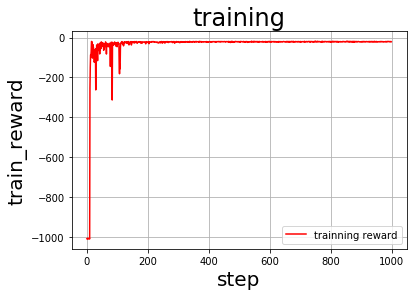

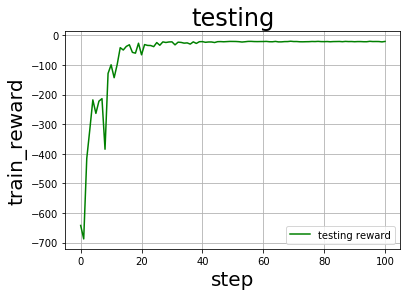

In [ ]:
draw_process("training",all_train_steps,all_train_rewards,"trainning reward", "red") 
draw_process("testing",all_test_steps,all_test_rewards,"testing reward", "green") 

## Step 7 Testing

In [15]:
######################################################################
######################################################################
#
# 7. 选择训练的模型文件做评估
#
######################################################################
######################################################################
ckpt = 'model_dir/final.ckpt'  # 可以设置ckpt为训练中效果最好的一次评估保存的模型文件名称

agent.restore(ckpt, mode='predict')
evaluate_reward = evaluate(env, agent)
logger.info('Evaluate reward: {}'.format(evaluate_reward)) # 打印评估的reward

[06-29 13:37:44 MainThread @<ipython-input-15-dc2a48c50783>:12] Evaluate reward: -20.3440190743928
